In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install dtw-python

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.7/801.7 kB 20.2 MB/s eta 0:00:00


In [2]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from dtw import dtw
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.metrics import specificity_score # specificity_score 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
import seaborn as sns

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
def t_smote(X, y, N, k, l_range, random_state=None):
    """
    T-SMOTE 알고리즘 구현 (DTW 사용, KNN 미사용)

    Args:
        X: 학습 데이터 (시계열 데이터)
        y: 레이블 (0 또는 1, 1이 소수 클래스)
        N: 생성할 샘플의 수 (소수 클래스 샘플 수의 배수)
        k: DTW에서 사용할 이웃의 수
        l_range: leading time 범위 (튜플 형태, 예: (1, 10))
        random_state: 난수 발생 시드 (선택 사항)

    Returns:
        합성된 샘플 데이터와 레이블
    """

    # 난수 발생기 초기화
    if random_state is not None:
        np.random.seed(random_state)

    T = X.shape[1] # 시계열 길이
    minority_indices = np.where(y == 1)[0]
    n_minority_samples = len(minority_indices)

    # N이 100%를 초과하는 경우
    N = int(N / 100 * n_minority_samples)

    synthetic_X = np.zeros((N, X.shape[1]))
    synthetic_y = np.ones(N) # 합성 데이터는 소수 클래스

    # 각 소수 클래스 샘플에 대해 N/num_minority 만큼 샘플 생성
    for i in range(N):
        # 1. 소수 클래스 샘플 선택
        idx = minority_indices[i % n_minority_samples]
        sample = X[idx]

        # 2. leading time 선택
        l = np.random.randint(l_range[0], l_range[1] + 1)

        # 3. 시간적 이웃 탐색 (DTW 사용)
        distances = [dtw(sample[l:], X[j, l:]).distance for j in minority_indices]
        nearest_indices = np.argsort(distances)[1:k+1] # 자기 자신 제외
        nearest_indices = minority_indices[nearest_indices] # 실제 인덱스로 변환

        # 4. 샘플 합성
        neighbor = X[nearest_indices[np.random.randint(0, k)]]
        diff = neighbor[l:] - sample[l:]
        synthetic_sample = sample.copy()
        synthetic_sample[l:] = sample[l:] + np.random.rand() * diff

        synthetic_X[i, l:] = synthetic_sample[l:] # leading time 이후 부분만 합성

    return synthetic_X, synthetic_y

In [5]:
# 1. 데이터 로드
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')


# 2. 데이터 전처리 (Numpy 배열로 변환)
X_train = df_X_train.values
y_train = df_y_train.values.ravel()
X_test = df_X_test.values
y_test = df_y_test.values.ravel()

# 3. 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 4. T-SMOTE 파라미터 설정 (데이터에 맞게 조정)
N = 100  # 생성할 샘플 수 (소수 클래스 샘플 수의 100%)
k = 5    # DTW 이웃 수
l_range = (1, 10) # leading time 범위

# 5. T-SMOTE 적용
synthetic_X, synthetic_y = t_smote(X_train, y_train, N, k, l_range, random_state=42)

# 6. ADASYN 적용 (T-SMOTE 효과가 없을 경우)
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# 7. RandomUnderSampler 적용 (과도한 오버샘플링 방지)
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority') # 'majority'로 설정하여 다수 클래스와 동일하게 샘플링
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_adasyn, y_train_adasyn)

# 8. T-SMOTE 적용 후 데이터셋 병합
X_synthetic = np.vstack((X_train_resampled, synthetic_X))
y_synthetic = np.hstack((y_train_resampled, synthetic_y))

# 9. 모델 정의 (Random Forest)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=10, min_samples_split=5, min_samples_leaf=2) # 클래스 가중치 balanced로 설정, max_depth 제한

# 10. Stratified K-Fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K-Fold 사용

In [10]:
# 11. 교차 검증 및 모델 학습
best_threshold = None
best_specificity = 0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)): #X_train_resampled, y_train_resampled로 학습
    print(f"Fold {fold+1}")

    # 데이터 분할
    X_train_fold, X_val_fold = X_train_resampled[train_index], X_train_resampled[val_index] #X_train_resampled, y_train_resampled로 학습
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index] #X_train_resampled, y_train_resampled로 학습

    # 모델 학습
    rf_model.fit(X_train_fold, y_train_fold)

    # 검증 데이터 예측 (확률값 예측)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]

    # 최적 임계값 찾기 (Specificity 최대화)
    thresholds = np.linspace(0, 1, 100)  # 임계값 후보 생성
    for threshold in thresholds:
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        specificity = specificity_score(y_val_fold, y_pred_temp)
        if specificity > best_specificity:
            best_specificity = specificity
            best_threshold = threshold
            best_model = rf_model # 현재 fold의 모델 저장

print(f"Best Threshold: {best_threshold}")

# 12. 테스트 데이터 예측 (최적 모델 및 임계값 사용)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Best Threshold: 0.797979797979798


In [16]:
# 예측 함수 정의 (최적 모델 및 임계값 사용)
def predict_with_best_rf(X_test):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    return (y_pred_proba >= best_threshold).astype(int)

# 예측 함수 정의
def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    # LSTM 모델 정의
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 데이터 차원 변경
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    # CNN 모델 정의
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 데이터 차원 변경
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:28:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Logistic Regression 모델 성능:
모델 성능 평가:
정확도: 0.6620
F1-Score: 0.7611
Recall: 0.8783
Specificity: 0.3193
혼동 행렬 (Confusion Matrix):
[[106 226]
 [ 64 462]]


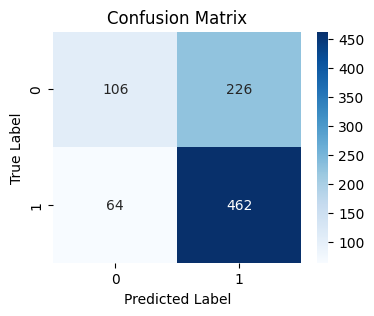

CART 모델 성능:
모델 성능 평가:
정확도: 0.6538
F1-Score: 0.7618
Recall: 0.9030
Specificity: 0.2590
혼동 행렬 (Confusion Matrix):
[[ 86 246]
 [ 51 475]]


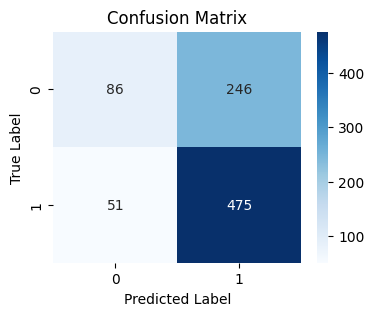

KNN 모델 성능:
모델 성능 평가:
정확도: 0.6853
F1-Score: 0.7761
Recall: 0.8897
Specificity: 0.3614
혼동 행렬 (Confusion Matrix):
[[120 212]
 [ 58 468]]


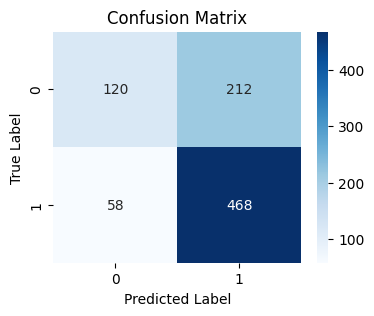

XGBoost 모델 성능:
모델 성능 평가:
정확도: 0.6807
F1-Score: 0.7856
Recall: 0.9544
Specificity: 0.2470
혼동 행렬 (Confusion Matrix):
[[ 82 250]
 [ 24 502]]


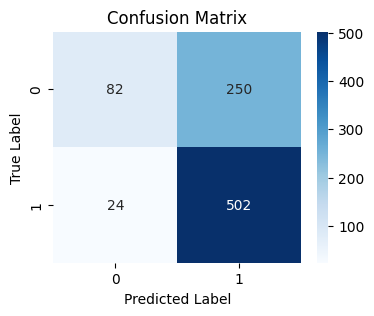

LSTM 모델 성능:
모델 성능 평가:
정확도: 0.6131
F1-Score: 0.7601
Recall: 1.0000
Specificity: 0.0000
혼동 행렬 (Confusion Matrix):
[[  0 332]
 [  0 526]]


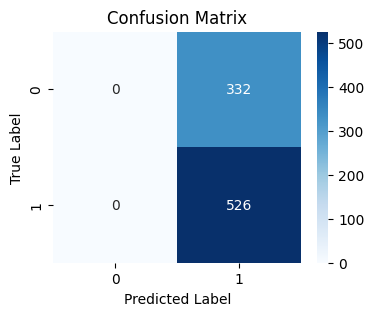

CNN 모델 성능:
모델 성능 평가:
정확도: 0.6620
F1-Score: 0.7766
Recall: 0.9582
Specificity: 0.1928
혼동 행렬 (Confusion Matrix):
[[ 64 268]
 [ 22 504]]


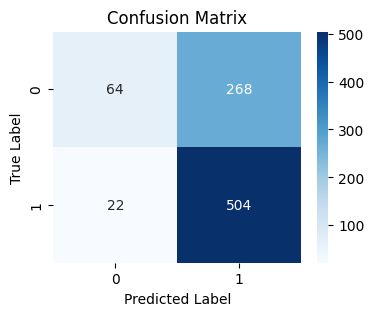

Best Random Forest 모델 성능:
모델 성능 평가:
정확도: 0.6643
F1-Score: 0.6674
Recall: 0.5494
Specificity: 0.8464
혼동 행렬 (Confusion Matrix):
[[281  51]
 [237 289]]


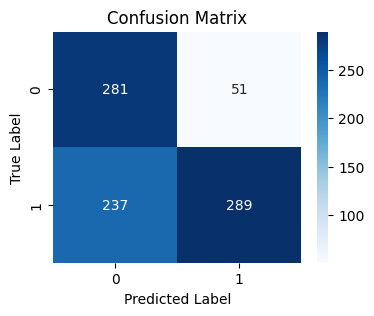

In [17]:
# 예측 결과 저장 (최적 RF 모델 포함)
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test),
    "Best Random Forest": predict_with_best_rf(X_test)  # 최적 RF 모델 예측
}

# 성능 평가
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    # 성능 지표 출력
    print(f"{model_name} 모델 성능:")
    print("모델 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()